In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [ ]:
import os
import torch
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.io import wavfile
from sklearn.metrics import mean_squared_error
import statistics
from scipy.signal import savgol_filter, butter, filtfilt

class Config:
    def __init__(self, **kwargs):
        self.batch_size = kwargs.get('batch_size', 16)
        self.epochs = kwargs.get('epochs', 10)
        self.lr = kwargs.get('lr', 0.001)
        self.channels_imu_acc = kwargs.get('channels_imu_acc', [])
        self.channels_imu_acc_test = kwargs.get('channels_imu_acc_test', [])
        self.channels_imu_gyr_test = kwargs.get('channels_imu_gyr_test', [])
        self.channels_imu_gyr = kwargs.get('channels_imu_gyr', [])
        self.channels_joints = kwargs.get('channels_joints', [])
        self.channels_emg = kwargs.get('channels_emg', [])
        self.seed = kwargs.get('seed', 42)
        self.data_folder_name = kwargs.get('data_folder_name', 'default_data_folder_name')
        self.dataset_root = kwargs.get('dataset_root', 'default_dataset_root')
        self.dataset_train_name = kwargs.get('dataset_train_name', 'train')
        self.dataset_test_name = kwargs.get('dataset_test_name', 'test')
        self.window_length = kwargs.get('window_length', 100)
        self.window_overlap = kwargs.get('window_overlap', 0)
        self.imu_transforms = kwargs.get('imu_transforms', [])
        self.joint_transforms = kwargs.get('joint_transforms', [])
        self.emg_transforms = kwargs.get('emg_transforms', [])
        self.hidden_size = kwargs.get('hidden_size', 256)
        self.num_layers = kwargs.get('num_layers', 6)
        self.input_size = kwargs.get('input_size', 3)
        self.output_size = kwargs.get('output_size', 3)
        self.sample_rate = kwargs.get('sample_rate', 100)
        self.input_format = kwargs.get('input_format', 'csv')
        self.train_subjects = kwargs.get('train_subjects', [])
        self.test_subjects = kwargs.get('test_subjects', [])

        self.dataset_name = self.generate_dataset_name()

    def generate_dataset_name(self):
        name = f"dataset_wl{self.window_length}_ol{self.window_overlap}_train{self.train_subjects}_test{self.test_subjects}"
        return name

In [ ]:
class DataSharder:
    def __init__(self, config, save_h5=False):
        self.config = config
        self.sample_rate = config.sample_rate
        self.input_format = config.input_format
        self.data_folder_path = config.data_folder_name
        self.window_length = int(config.window_length)
        self.window_overlap = int(config.window_overlap)
        self.save_h5 = save_h5

    def load_data(self):
        print(f"Training subjects: {self.config.train_subjects}")
        print(f"Testing subjects: {self.config.test_subjects}")

        if self.input_format == 'wav':
            self._process_and_save_patients_wav(self.config.train_subjects, "train")
            self._process_and_save_patients_wav(self.config.test_subjects, "test")
        elif self.input_format == 'csv':
            self._process_and_save_patients_csv(self.config.train_subjects, "train")
            self._process_and_save_patients_csv(self.config.test_subjects, "test")
        else:
            raise ValueError(f"Unsupported input format: {self.input_format}")

    def _process_and_save_patients_wav(self, patient_id_list, split):
        total_data = []
        for patient_id in tqdm(patient_id_list, desc=f"Processing {split} patients"):
            for session_index in tqdm(range(len(self.config.train_subjects)), desc=f"Processing sessions for {patient_id}", leave=False):
                imu_data, imu_sample_rate = self._load_wav_file(patient_id, session_index, "IMU")
                joints_data, joints_sample_rate = self._load_wav_file(patient_id, session_index, "JOINTS")
                emg_data, emg_sample_rate = self._load_wav_file(patient_id, session_index, "EMG")

                imu_data = self._resample_data(imu_data, imu_sample_rate)
                joints_data = self._resample_data(joints_data, joints_sample_rate)
                emg_data = self._resample_data(emg_data, emg_sample_rate)

                combined_data = torch.cat((imu_data, joints_data, emg_data), dim=1)
                total_data.append(combined_data.cpu().numpy())

        if self.save_h5:
            self._save_to_h5(total_data, split)
        else:
            for combined_data in total_data:
                self._save_windowed_data(combined_data, patient_id, session_index, split)

    def _load_wav_file(self, patient_id, session_index, file_type):
        file_path = os.path.join(self.data_folder_path, patient_id, f"run{session_index}_{file_type}.wav")
        data, sample_rate = get_data_from_wav_file(file_path)
        return torch.tensor(data, dtype=torch.float32), sample_rate

    def _resample_data(self, data, sample_rate):
        if sample_rate != self.sample_rate:
            data = torch.nn.functional.interpolate(data.unsqueeze(0), size=self.sample_rate, mode='linear').squeeze(0)
        return data

    def _process_and_save_patients_csv(self, patient_id_list, split):
        column_names = None
        for patient_id in tqdm(patient_id_list, desc=f"Processing {split} patients"):
            combined_path = os.path.join(self.data_folder_path, patient_id, "combined")
            if not os.path.exists(combined_path):
                print(f"Directory {combined_path} does not exist. Skipping patient {patient_id}.")
                continue

            patient_files = os.listdir(combined_path)
            for session_file in tqdm(patient_files, desc=f"Processing sessions for {patient_id}", leave=False):
                data = pd.read_csv(os.path.join(combined_path, session_file))
                if column_names is None:
                    column_names = data.columns.tolist()  # Convert Index to list
                data_np = data.to_numpy()
                # Pad array to fit columns if necessary
                if data_np.shape[1] < len(column_names):
                    data_np = np.pad(data_np, ((0, 0), (0, len(column_names) - data_np.shape[1])), mode='constant')
                elif data_np.shape[1] > len(column_names):
                    # Extend column names to match the data shape
                    extra_columns = [f"extra_{i}" for i in range(data_np.shape[1] - len(column_names))]
                    column_names.extend(extra_columns)

                self._save_windowed_data(pd.DataFrame(data_np, columns=column_names), patient_id, session_file.split('.')[0], split, is_csv=True)

    def _save_windowed_data(self, data, patient_id, session_id, split, is_csv=False):
        dataset_folder = os.path.join(self.config.dataset_root, self.config.dataset_name, self.config.dataset_train_name if split == "train" else self.config.dataset_test_name)
        os.makedirs(dataset_folder, exist_ok=True)

        window_size = self.window_length
        overlap = self.window_overlap
        step_size = window_size - overlap

        data_info_list = []

        for i in tqdm(range(0, len(data) - window_size + 1, step_size), desc=f"Windowing data for {patient_id}_{session_id}", leave=False):
            windowed_data = data.iloc[i:i+window_size] if is_csv else data[i:i+window_size]
            if windowed_data.shape[0] < window_size:
                continue

            windowed_data_np = windowed_data.to_numpy() if is_csv else windowed_data.cpu().numpy()

            file_name = f"{patient_id}_session_{session_id}_window_{i}_ws{window_size}_ol{overlap}.csv"
            file_path = os.path.join(dataset_folder, file_name)
            pd.DataFrame(windowed_data_np, columns=data.columns if is_csv else None).to_csv(file_path, index=False)
            data_info_list.append({"file_name": file_name, "file_path": file_path})

        data_info_df = pd.DataFrame(data_info_list)
        data_info_df.to_csv(os.path.join(self.config.dataset_root, self.config.dataset_name, f"{split}_info.csv"), index=False, mode='a', header=not os.path.exists(os.path.join(self.config.dataset_root, self.config.dataset_name, f"{split}_info.csv")))


In [1]:
class ImuJointPairDataset(Dataset):
    def __init__(self, config, split='train'):
        self.config = config
        self.split = split
        self.input_format = config.input_format
        self.channels_imu_acc = config.channels_imu_acc
        self.channels_imu_acc_test = config.channels_imu_acc_test
        self.channels_imu_gyr = config.channels_imu_gyr
        self.channels_imu_gyr_test = config.channels_imu_gyr_test
        self.channels_joints = config.channels_joints
        self.channels_emg = config.channels_emg

        dataset_name = self.config.dataset_name
        self.root_dir_train = os.path.join(self.config.dataset_root, dataset_name, self.config.dataset_train_name)
        self.root_dir_test = os.path.join(self.config.dataset_root, dataset_name, self.config.dataset_test_name)

        train_info_path = os.path.join(self.config.dataset_root, dataset_name, "train_info.csv")
        test_info_path = os.path.join(self.config.dataset_root, dataset_name, "test_info.csv")
        self.data = pd.read_csv(train_info_path) if split == 'train' else pd.read_csv(test_info_path)

        self.scaler_save_path = os.path.join(self.config.dataset_root, dataset_name, "scaler.pkl")
        self.scaler = joblib.load(self.scaler_save_path) if os.path.exists(self.scaler_save_path) else None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.split == "train":
            file_path = os.path.join(self.root_dir_train, self.data.iloc[idx, 0])
        else:
            file_path = os.path.join(self.root_dir_test, self.data.iloc[idx, 0])

        if self.input_format == "wav":
            combined_data, _ = get_data_from_wav_file(file_path)
        elif self.input_format == "csv":
            combined_data = pd.read_csv(file_path)
        else:
            raise ValueError("Unsupported input format: {}".format(self.input_format))

        imu_data_acc, imu_data_gyr, joint_data, emg_data = self._extract_and_transform(combined_data)
        windows = self._apply_windowing(imu_data_acc, imu_data_gyr, joint_data, emg_data, self.config.window_length, self.config.window_overlap)

        acc_concat = np.concatenate([w[0] for w in windows], axis=0)
        gyr_concat = np.concatenate([w[1] for w in windows], axis=0)
        joint_concat = np.concatenate([w[2] for w in windows], axis=0)
        emg_concat = np.concatenate([w[3] for w in windows], axis=0)

        return acc_concat, gyr_concat, joint_concat, emg_concat

    def _extract_and_transform(self, combined_data):
        imu_data_acc = self._extract_channels(combined_data, self.channels_imu_acc)
        imu_data_gyr = self._extract_channels(combined_data, self.channels_imu_gyr)
        joint_data = self._extract_channels(combined_data, self.channels_joints)
        emg_data = self._extract_channels(combined_data, self.channels_emg)

        combined_data = np.concatenate([imu_data_acc, imu_data_gyr, joint_data, emg_data], axis=1)
        scaled_data = combined_data

        imu_data_acc = scaled_data[:, :imu_data_acc.shape[1]]
        imu_data_gyr = scaled_data[:, imu_data_acc.shape[1]:imu_data_acc.shape[1] + imu_data_gyr.shape[1]]
        joint_data = scaled_data[:, imu_data_acc.shape[1] + imu_data_gyr.shape[1]:imu_data_acc.shape[1] + imu_data_gyr.shape[1] + joint_data.shape[1]]
        emg_data = scaled_data[:, imu_data_acc.shape[1] + imu_data_gyr.shape[1] + joint_data.shape[1]:]

        imu_data_acc = self.apply_transforms(imu_data_acc, self.config.imu_transforms)
        imu_data_gyr = self.apply_transforms(imu_data_gyr, self.config.imu_transforms)
        joint_data = self.apply_transforms(joint_data, self.config.joint_transforms)
        emg_data = self.apply_transforms(emg_data, self.config.emg_transforms)

        return imu_data_acc, imu_data_gyr, joint_data, emg_data

    def _extract_channels(self, combined_data, channels):
        if isinstance(channels, slice):
            return combined_data.iloc[:, channels].values if self.input_format == "csv" else combined_data[:, channels]
        else:
            return combined_data[channels].values if self.input_format == "csv" else combined_data[:, channels]

    def _apply_windowing(self, imu_data_acc, imu_data_gyr, joint_data, emg_data, window_length, window_overlap):
        num_samples = imu_data_acc.shape[0]
        step = window_length - window_overlap
        windows = []

        for start in range(0, num_samples - window_length + 1, step):
            end = start + window_length
            window = (
                imu_data_acc[start:end],
                imu_data_gyr[start:end],
                joint_data[start:end],
                emg_data[start:end]
            )
            windows.append(window)

        return windows

    def apply_transforms(self, data, transforms):
        for transform in transforms:
            data = transform(data)
        data = torch.tensor(data, dtype=torch.float32)
        return data


NameError: name 'Dataset' is not defined

In [ ]:
#prediction function
def RMSE_prediction(yhat_4,test_y, output_dim):

  s1=yhat_4.shape[0]*yhat_4.shape[1]

  test_o=test_y.reshape((s1,output_dim))
  yhat=yhat_4.reshape((s1,output_dim))




  y_1_no=yhat[:,0]
  y_2_no=yhat[:,1]
  y_3_no=yhat[:,2]
  #y_4_no=yhat[:,3]
  #y_5_no=yhat[:,4]
  #y_6_no=yhat[:,5]
  #y_7_no=yhat[:,6]
  #y_8_no=yhat[:,7]
  #y_9_no=yhat[:,8]
  #y_10_no=yhat[:,9]


  y_1=y_1_no
  y_2=y_2_no
  y_3=y_3_no
  #y_4=y_4_no
  #y_5=y_5_no
  #y_6=y_6_no
  #y_7=y_7_no



  y_test_1=test_o[:,0]
  y_test_2=test_o[:,1]
  y_test_3=test_o[:,2]
  #y_test_4=test_o[:,3]
  #y_test_5=test_o[:,4]
  #y_test_6=test_o[:,5]
  #y_test_7=test_o[:,6]
  #y_test_8=test_o[:,7]
  #y_test_9=test_o[:,8]
  #y_test_10=test_o[:,9]





  #print(y_1.shape,y_test_1.shape)


  cutoff=6
  fs=200
  order=4

  nyq = 0.5 * fs
  ## filtering data ##
  def butter_lowpass_filter(data, cutoff, fs, order):
      normal_cutoff = cutoff / nyq
      # Get the filter coefficients
      b, a = butter(order, normal_cutoff, btype='low', analog=False)
      y = filtfilt(b, a, data)
      return y



  # y_1=butter_lowpass_filter(y_1_no, cutoff, fs, order)
  # y_2=butter_lowpass_filter(y_2_no, cutoff, fs, order)
  # y_3=butter_lowpass_filter(y_3_no, cutoff, fs, order)
  # y_4=butter_lowpass_filter(y_4_no, cutoff, fs, order)
  # y_5=butter_lowpass_filter(y_5_no, cutoff, fs, order)
  # y_6=butter_lowpass_filter(y_6_no, cutoff, fs, order)
  # y_7=butter_lowpass_filter(y_7_no, cutoff, fs, order)
  #y_8=butter_lowpass_filter(y_8_no, cutoff, fs, order)
  #y_9=butter_lowpass_filter(y_9_no, cutoff, fs, order)
  #y_10=butter_lowpass_filter(y_10_no, cutoff, fs, order)




  Z_1=y_1
  Z_2=y_2
  Z_3=y_3
  #Z_4=y_4
  #Z_5=y_5
  #Z_6=y_6
  #Z_7=y_7
  #Z_8=y_8
  #Z_9=y_9
  #Z_10=y_10



  ###calculate RMSE

  rmse_1 =((np.sqrt(mean_squared_error(y_test_1,y_1))))
  rmse_2 =((np.sqrt(mean_squared_error(y_test_2,y_2))))
  rmse_3 =((np.sqrt(mean_squared_error(y_test_3,y_3))))
  #rmse_4 =((np.sqrt(mean_squared_error(y_test_4,y_4)))/(max(y_test_4)-min(y_test_4)))*100
  #rmse_5 =((np.sqrt(mean_squared_error(y_test_5,y_5)))/(max(y_test_5)-min(y_test_5)))*100
  #rmse_6 =((np.sqrt(mean_squared_error(y_test_6,y_6)))/(max(y_test_6)-min(y_test_6)))*100
  #rmse_7 =((np.sqrt(mean_squared_error(y_test_7,y_7)))/(max(y_test_7)-min(y_test_7)))*100
  #rmse_8 =((np.sqrt(mean_squared_error(y_test_8,y_8)))/(max(y_test_8)-min(y_test_8)))*100
  #rmse_9 =((np.sqrt(mean_squared_error(y_test_9,y_9)))/(max(y_test_9)-min(y_test_9)))*100
  #rmse_10 =((np.sqrt(mean_squared_error(y_test_10,y_10)))/(max(y_test_10)-min(y_test_10)))*100


  print(rmse_1)
  print(rmse_2)
  print(rmse_3)
  #print(rmse_4)
  #print(rmse_5)
  #print(rmse_6)
  #print(rmse_7)
  #print(rmse_8)
  #print(rmse_9)
  #print(rmse_10)


  p_1=np.corrcoef(y_1, y_test_1)[0, 1]
  p_2=np.corrcoef(y_2, y_test_2)[0, 1]
  p_3=np.corrcoef(y_3, y_test_3)[0, 1]
  #p_4=np.corrcoef(y_4, y_test_4)[0, 1]
  #p_5=np.corrcoef(y_5, y_test_5)[0, 1]
  #p_6=np.corrcoef(y_6, y_test_6)[0, 1]
  #p_7=np.corrcoef(y_7, y_test_7)[0, 1]
  #p_8=np.corrcoef(y_8, y_test_8)[0, 1]
  #p_9=np.corrcoef(y_9, y_test_9)[0, 1]
  #p_10=np.corrcoef(y_10, y_test_10)[0, 1]


  print("\n")
  print(p_1)
  print(p_2)
  print(p_3)
  #print(p_4)
  #print(p_5)
  #print(p_6)
  #print(p_7)
  #print(p_8)
  #print(p_9)
  #print(p_10)


              ### Correlation ###
  p=np.array([p_1,p_2,p_3])
  #,p_4,p_5,p_6,p_7])




      #### Mean and standard deviation ####

  rmse=np.array([rmse_1,rmse_2,rmse_3])
  #,rmse_4,rmse_5,rmse_6,rmse_7])

      #### Mean and standard deviation ####
  m=statistics.mean(rmse)
  SD=statistics.stdev(rmse)
  print('Mean: %.3f' % m,'+/- %.3f' %SD)

  m_c=statistics.mean(p)
  SD_c=statistics.stdev(p)
  print('Mean: %.3f' % m_c,'+/- %.3f' %SD_c)



  return rmse, p, Z_1,Z_2,Z_3
  #,Z_4,Z_5,Z_6,Z_7



############################################################################################################################################################################################################################################################################################################################################################################################################################################################################


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
class Encoder_1(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_1, self).__init__()
        self.lstm_1 = nn.LSTM(input_dim, 128, bidirectional=True, batch_first=True, dropout=0.0)
        self.lstm_2 = nn.LSTM(256, 64, bidirectional=True, batch_first=True, dropout=0.0)
        self.flatten=nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)


    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1=self.dropout_1(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2=self.dropout_2(out_2)

        return out_2




class Encoder_2(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_2, self).__init__()
        self.lstm_1 = nn.GRU(input_dim, 128, bidirectional=True, batch_first=True, dropout=0.0)
        self.lstm_2 = nn.GRU(256, 64, bidirectional=True, batch_first=True, dropout=0.0)
        self.flatten=nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)


    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1=self.dropout_1(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2=self.dropout_2(out_2)

        return out_2


class GatingModule(nn.Module):
    def __init__(self, input_size):
        super(GatingModule, self).__init__()
        self.gate = nn.Sequential(
            nn.Linear(2*input_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, input1, input2):
        # Apply gating mechanism
        gate_output = self.gate(torch.cat((input1,input2),dim=-1))

        # Scale the inputs based on the gate output
        gated_input1 = input1 * gate_output
        gated_input2 = input2 * (1 - gate_output)

        # Combine the gated inputs
        output = gated_input1 + gated_input2
        return output
#variable w needs to be checked for correct value, stand-in value used
class teacher(nn.Module):
    def __init__(self, input_acc, input_gyr, input_emg, drop_prob=0.25, w=100):
        super(teacher, self).__init__()

        self.w=w
        self.encoder_1_acc=Encoder_1(input_acc, drop_prob)
        self.encoder_1_gyr=Encoder_1(input_gyr, drop_prob)
        self.encoder_1_emg=Encoder_1(input_emg, drop_prob)

        self.encoder_2_acc=Encoder_2(input_acc, drop_prob)
        self.encoder_2_gyr=Encoder_2(input_gyr, drop_prob)
        self.encoder_2_emg=Encoder_2(input_emg, drop_prob)

        self.BN_acc= nn.BatchNorm1d(input_acc, affine=False)
        self.BN_gyr= nn.BatchNorm1d(input_gyr, affine=False)
        self.BN_emg= nn.BatchNorm1d(input_emg, affine=False)


        self.fc = nn.Linear(2*3*128+128,3)
        self.dropout=nn.Dropout(p=0.05)

        self.gate_1=GatingModule(128)
        self.gate_2=GatingModule(128)
        self.gate_3=GatingModule(128)

        self.fc_kd = nn.Linear(3*128, 2*128)

               # Define the gating network
        self.weighted_feat = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid())

        self.attention=nn.MultiheadAttention(3*128,4,batch_first=True)
        self.gating_net = nn.Sequential(nn.Linear(128*3, 3*128), nn.Sigmoid())
        self.gating_net_1 = nn.Sequential(nn.Linear(2*3*128+128, 2*3*128+128), nn.Sigmoid())

        self.pool = nn.MaxPool1d(kernel_size=2)


    def forward(self, x_acc, x_gyr, x_emg):

        x_acc_1=x_acc.view(x_acc.size(0)*x_acc.size(1),x_acc.size(-1))
        x_gyr_1=x_gyr.view(x_gyr.size(0)*x_gyr.size(1),x_gyr.size(-1))
        x_emg_1=x_emg.view(x_emg.size(0)*x_emg.size(1),x_emg.size(-1))

        x_acc_1=self.BN_acc(x_acc_1)
        x_gyr_1=self.BN_gyr(x_gyr_1)
        x_emg_1=self.BN_emg(x_emg_1)

        x_acc_2=x_acc_1.view(-1, self.w, x_acc_1.size(-1))
        x_gyr_2=x_gyr_1.view(-1, self.w, x_gyr_1.size(-1))
        x_emg_2=x_emg_1.view(-1, self.w, x_emg_1.size(-1))

        x_acc_1=self.encoder_1_acc(x_acc_2)
        x_gyr_1=self.encoder_1_gyr(x_gyr_2)
        x_emg_1=self.encoder_1_emg(x_emg_2)

        x_acc_2=self.encoder_2_acc(x_acc_2)
        x_gyr_2=self.encoder_2_gyr(x_gyr_2)
        x_emg_2=self.encoder_2_emg(x_emg_2)

        # x_acc=torch.cat((x_acc_1,x_acc_2),dim=-1)
        # x_gyr=torch.cat((x_gyr_1,x_gyr_2),dim=-1)
        # x_emg=torch.cat((x_emg_1,x_emg_2),dim=-1)

        x_acc=self.gate_1(x_acc_1,x_acc_2)
        x_gyr=self.gate_2(x_gyr_1,x_gyr_2)
        x_emg=self.gate_3(x_emg_1,x_emg_2)

        x=torch.cat((x_acc,x_gyr,x_emg),dim=-1)
        x_kd=self.fc_kd(x)


        out_1, attn_output_weights=self.attention(x,x,x)

        gating_weights = self.gating_net(x)
        out_2=gating_weights*x

        weights_1 = self.weighted_feat(x[:,:,0:128])
        weights_2 = self.weighted_feat(x[:,:,128:2*128])
        weights_3 = self.weighted_feat(x[:,:,2*128:3*128])
        x_1=weights_1*x[:,:,0:128]
        x_2=weights_2*x[:,:,128:2*128]
        x_3=weights_3*x[:,:,2*128:3*128]
        out_3=x_1+x_2+x_3

        out=torch.cat((out_1,out_2,out_3),dim=-1)

        gating_weights_1 = self.gating_net_1(out)
        out=gating_weights_1*out

        out=self.fc(out)

        #print(out.shape)
        return out,x_kd


class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
    def forward(self, output, target):
        loss = torch.sqrt(torch.mean((output - target) ** 2))
        return loss




In [ ]:
def evaluate_model(model, loader, output_dim=3):
    model.eval()
    yhat_5 = []
    test_target = []

    with torch.no_grad():
        for i, (data_acc, data_gyr, target, data_EMG) in enumerate(loader):
            output, _ = model(data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float())
            yhat_5.append(output)
            test_target.append(target)

            # clear memory
            del data_acc, data_gyr, target, data_EMG, output
            torch.cuda.empty_cache()

    yhat_4 = torch.cat(yhat_5, dim=0).detach().cpu().numpy()
    test_target = torch.cat(test_target, dim=0).detach().cpu().numpy()
    print(yhat_4.shape)

    rmse, p, Z_1, Z_2, Z_3 = RMSE_prediction(yhat_4, test_target, output_dim=output_dim)
    return np.hstack([rmse, p])


In [ ]:
def process_file(file_path, teacher_model):
    df = pd.read_csv(file_path)
    print("processing file {}".format(file_path))

    columns_imu_acc = config.channels_imu_acc
    columns_imu_gyr = config.channels_imu_gyr
    columns_joints = config.channels_joints

    input_acc = df[columns_imu_acc].values
    input_gyr = df[columns_imu_gyr].values
    input_emg = df[config.channels_emg].values
    target_data = df[columns_joints].values

    acc_tensor = torch.tensor(input_acc, dtype=torch.float32).unsqueeze(0)
    gyr_tensor = torch.tensor(input_gyr, dtype=torch.float32).unsqueeze(0)
    emg_tensor = torch.tensor(input_emg, dtype=torch.float32).unsqueeze(0)
    target_tensor = torch.tensor(target_data, dtype=torch.float32).unsqueeze(0)

    window_size = 100
    predictions_teacher = []

    with torch.no_grad():
        for i in range(0, acc_tensor.shape[1] - window_size + 1, window_size):
            acc_window = acc_tensor[:, i:i + window_size, :].to(device)
            gyr_window = gyr_tensor[:, i:i + window_size, :].to(device)
            emg_window = emg_tensor[:, i:i + window_size, :].to(device)

            output, _ = teacher_model(acc_window, gyr_window, emg_window)
            predictions_teacher.append(output.cpu().numpy())

    predictions_teacher = np.concatenate(predictions_teacher, axis=1)
    predictions_teacher = predictions_teacher.reshape(-1, predictions_teacher.shape[-1])
    target_tensor_np = target_tensor.cpu().numpy().squeeze(0)[:predictions_teacher.shape[0]]

    # Plot predictions vs ground truth for each channel
    num_channels = predictions_teacher.shape[1]

    fig, axes = plt.subplots(1, num_channels, figsize=(5 * num_channels, 5))

    for channel in range(num_channels):
        ax = axes[channel]
        ax.plot(target_tensor_np[:1000, channel], label='Ground Truth')
        ax.plot(predictions_teacher[:1000, channel], label='Teacher Predicted')
        ax.set_title(f'{os.path.basename(file_path)} - Channel {channel + 1}')
        ax.set_xlabel('Samples')
        ax.set_ylabel('Value')
        ax.set_ylim(-180, 180)
        ax.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config(
    data_folder_name='/content/MyDrive/MyDrive/sd_datacollection_v2',
    dataset_root='/content/MyDrive/MyDrive/datasets_v2',
    dataset_train_name='train',
    dataset_test_name='test',
    batch_size=64,
    epochs=10,
    lr=0.001,
    window_length=100,
    window_overlap=75,
    input_format="csv",
    channels_imu_acc=['ACCX1', 'ACCY1', 'ACCZ1', 'ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_acc_test=['ACCX1', 'ACCY1', 'ACCZ1', 'ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_gyr=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_imu_gyr_test=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_joints=['elbow_flex_r', 'arm_flex_r', 'arm_add_r'],
    channels_emg=['IM EMG4', 'IM EMG5', 'IM EMG6'],
    train_subjects=['subject_10', 'subject_2','subject_3','subject_7','subject_9'],
    test_subjects=['subject_1']
)




In [ ]:
import torch

# Assuming `teacher` is the model class and `device` is defined
model = teacher(18, 18, 3)

# Load the entire checkpoint
checkpoint = torch.load("/content/MyDrive/MyDrive/models/Vanilla_SD_csv_RMSE_gridsearchtraining_smalldataset_fulldata_[1,2,3,7,9,10]/retrained_teacher_model_train_subject_10_subject_2_subject_3_subject_7_subject_9_test_subject_1_epoch_175.pth")

# Extract the model state dictionary
state_dict = checkpoint['model_state_dict']

# Load state dictionary into model
model.load_state_dict(state_dict)

model.to(device)
model.eval()


teacher(
  (encoder_1_acc): Encoder_1(
    (lstm_1): LSTM(18, 128, batch_first=True, bidirectional=True)
    (lstm_2): LSTM(256, 64, batch_first=True, bidirectional=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc): Linear(in_features=128, out_features=32, bias=True)
    (dropout_1): Dropout(p=0.25, inplace=False)
    (dropout_2): Dropout(p=0.25, inplace=False)
  )
  (encoder_1_gyr): Encoder_1(
    (lstm_1): LSTM(18, 128, batch_first=True, bidirectional=True)
    (lstm_2): LSTM(256, 64, batch_first=True, bidirectional=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc): Linear(in_features=128, out_features=32, bias=True)
    (dropout_1): Dropout(p=0.25, inplace=False)
    (dropout_2): Dropout(p=0.25, inplace=False)
  )
  (encoder_1_emg): Encoder_1(
    (lstm_1): LSTM(3, 128, batch_first=True, bidirectional=True)
    (lstm_2): LSTM(256, 64, batch_first=True, bidirectional=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc): Linear(in_features=128, out_

In [ ]:
#inidialize test dataset

from sklearn.metrics import mean_squared_error
from scipy.signal import butter, filtfilt
import glob
import seaborn as sns
sns.set_theme("paper")

test_dataset = ImuJointPairDataset(config,split="Test")
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

#evaluate model on test_loader
results = evaluate_model(model, test_loader, output_dim=3)
print(results)

(1265, 100, 3)
10.456203
17.21336
5.277876


0.9734610193204536
0.9874807410488688
0.8736456267900957
Mean: 10.982 +/- 5.985
Mean: 0.945 +/- 0.062
[10.45620346 17.21335983  5.2778759   0.97346102  0.98748074  0.87364563]


In [63]:

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def RMSE_prediction(yhat_4, test_y, output_dim, cutoff, order):
    s1 = yhat_4.shape[0] * yhat_4.shape[1]
    test_o = test_y.reshape((s1, output_dim))
    yhat = yhat_4.reshape((s1, output_dim))

    y_1_no, y_2_no, y_3_no = yhat[:, 0], yhat[:, 1], yhat[:, 2]
    y_test_1, y_test_2, y_test_3 = test_o[:, 0], test_o[:, 1], test_o[:, 2]

    fs = 200

    if order > 0 and cutoff > 0:
        y_1 = butter_lowpass_filter(y_1_no, cutoff, fs, order)
        y_2 = butter_lowpass_filter(y_2_no, cutoff, fs, order)
        y_3 = butter_lowpass_filter(y_3_no, cutoff, fs, order)
    else:
        y_1 = y_1_no
        y_2 = y_2_no
        y_3 = y_3_no

    rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_1))
    rmse_2 = np.sqrt(mean_squared_error(y_test_2, y_2))
    rmse_3 = np.sqrt(mean_squared_error(y_test_3, y_3))

    total_rmse = np.mean([rmse_1, rmse_2, rmse_3])
    return total_rmse

def calculate_total_rmse_and_pcc(loader, output_dim, cutoff, order):
    model.eval()
    yhat_5 = []
    test_target = []

    with torch.no_grad():
        for i, (data_acc, data_gyr, target, data_EMG) in enumerate(loader):
            output, _ = model(data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float())
            yhat_5.append(output)
            test_target.append(target)

            # clear memory
            del data_acc, data_gyr, target, data_EMG, output
            torch.cuda.empty_cache()

    yhat_4 = torch.cat(yhat_5, dim=0).detach().cpu().numpy()
    test_target = torch.cat(test_target, dim=0).detach().cpu().numpy()

    return RMSE_prediction(yhat_4, test_target, output_dim, cutoff, order)

def optimize_filter_params(loader, output_dim, learning_rate=0.1, epochs=100):
    cutoff = 0.1  # Initial cutoff frequency (small positive value)
    order = 1     # Start with a small positive filter order

    for epoch in range(epochs):
        # Calculate current RMSE and PCC
        current_rmse = calculate_total_rmse_and_pcc(loader, output_dim, cutoff, order)

        # Calculate gradients
        cutoff_rmse_grad = (calculate_total_rmse_and_pcc(loader, output_dim, cutoff + 0.01, order) - current_rmse) / 0.01
        order_rmse_grad = (calculate_total_rmse_and_pcc(loader, output_dim, cutoff, order + 1) - current_rmse)

        # Update parameters
        cutoff -= learning_rate * cutoff_rmse_grad
        order -= learning_rate * order_rmse_grad

        # Ensure order remains an integer and nonnegative, and cutoff remains positive
        order = max(1, int(round(order)))  # Ensure order starts from 1
        cutoff = max(0.01, cutoff)  # Cutoff must be greater than 0

        print(f'Epoch {epoch+1}/{epochs} - RMSE: {current_rmse:.4f} - Cutoff: {cutoff:.4f} - Order: {order}')

    return cutoff, order

# Optimize filter parameters based on the entire test_loader
best_cutoff, best_order = optimize_filter_params(test_loader, output_dim=3)

# Redefine RMSE_prediction with the optimized parameters
def RMSE_prediction(yhat_4, test_y, output_dim):
    return RMSE_prediction(yhat_4, test_y, output_dim, best_cutoff, best_order)

# Now you can call the evaluate_model function without changing it
results = evaluate_model(model, test_loader, output_dim=3)
print("RMSE and PCC:", results)

Epoch 1/100 - RMSE: 25.2849 - Cutoff: 5.2140 - Order: 1
Epoch 2/100 - RMSE: 12.4983 - Cutoff: 5.2433 - Order: 1
Epoch 3/100 - RMSE: 12.4897 - Cutoff: 5.2723 - Order: 1
Epoch 4/100 - RMSE: 12.4813 - Cutoff: 5.3010 - Order: 1
Epoch 5/100 - RMSE: 12.4731 - Cutoff: 5.3294 - Order: 1
Epoch 6/100 - RMSE: 12.4651 - Cutoff: 5.3574 - Order: 1
Epoch 7/100 - RMSE: 12.4573 - Cutoff: 5.3852 - Order: 1
Epoch 8/100 - RMSE: 12.4496 - Cutoff: 5.4126 - Order: 1
Epoch 9/100 - RMSE: 12.4421 - Cutoff: 5.4398 - Order: 1
Epoch 10/100 - RMSE: 12.4347 - Cutoff: 5.4667 - Order: 1
Epoch 11/100 - RMSE: 12.4275 - Cutoff: 5.4934 - Order: 1
Epoch 12/100 - RMSE: 12.4204 - Cutoff: 5.5197 - Order: 1
Epoch 13/100 - RMSE: 12.4135 - Cutoff: 5.5459 - Order: 1
Epoch 14/100 - RMSE: 12.4067 - Cutoff: 5.5717 - Order: 1
Epoch 15/100 - RMSE: 12.4000 - Cutoff: 5.5974 - Order: 1
Epoch 16/100 - RMSE: 12.3934 - Cutoff: 5.6228 - Order: 1
Epoch 17/100 - RMSE: 12.3870 - Cutoff: 5.6480 - Order: 1


KeyboardInterrupt: 

Found 10 files for processing.
Processing file: /content/MyDrive/MyDrive/sd_datacollection_v2/subject_1/combined/P001_T001_crossbody_fast_combined.csv
processing file /content/MyDrive/MyDrive/sd_datacollection_v2/subject_1/combined/P001_T001_crossbody_fast_combined.csv
predictions_teacher shape: (3300, 3)
target_tensor_np shape: (3300, 3)
RMSE without filter: 16.508514 12.392405 5.558738
RMSE with filter: 16.441770684422472 12.30175303855923 5.461597347367694

Correlation without filter: -0.2668070980269208 0.9904274832838211 0.9300608709311031
Correlation with filter: -0.27229278458431716 0.9912852863961839 0.932603771809456
Processing file: /content/MyDrive/MyDrive/sd_datacollection_v2/subject_1/combined/P001_T001_crossbody_slow_combined.csv
processing file /content/MyDrive/MyDrive/sd_datacollection_v2/subject_1/combined/P001_T001_crossbody_slow_combined.csv
predictions_teacher shape: (3300, 3)
target_tensor_np shape: (3300, 3)
RMSE without filter: 14.663664 12.08627 9.544042
RMSE wi

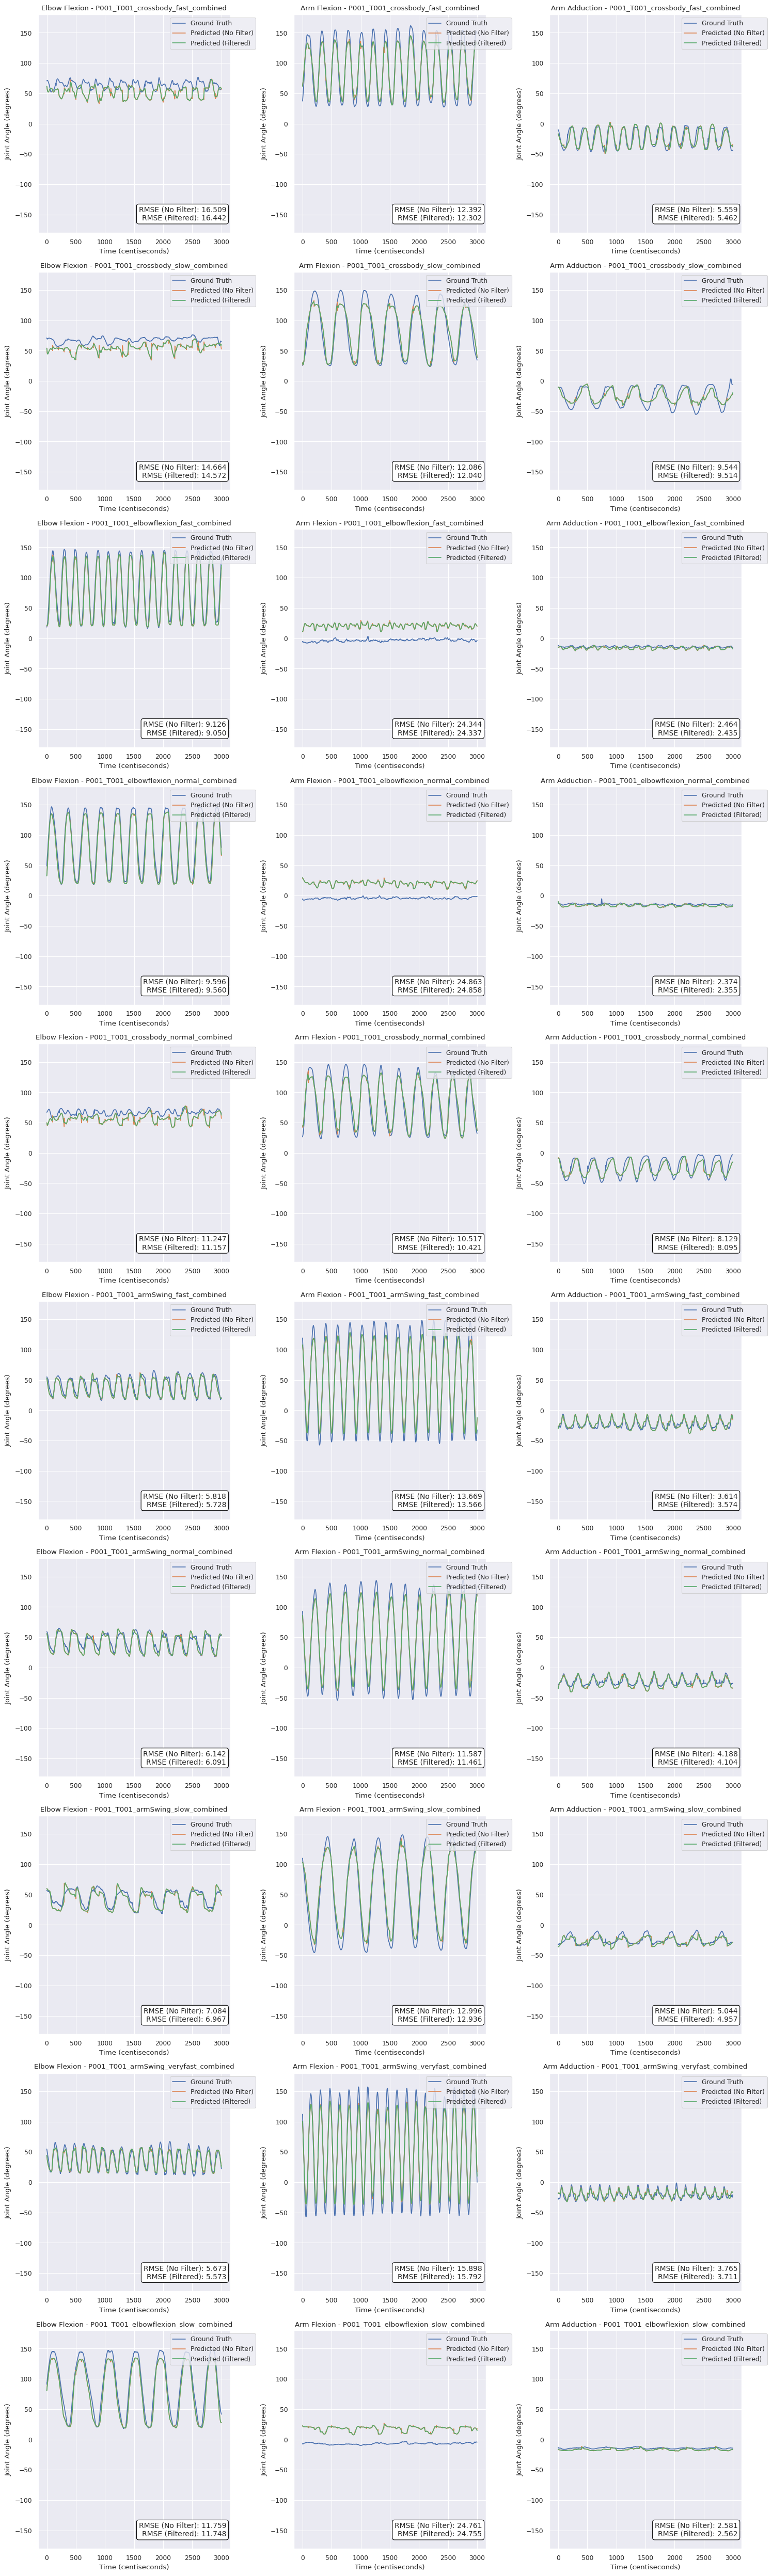

In [ ]:

from sklearn.metrics import mean_squared_error
from scipy.signal import butter, filtfilt
import glob
import seaborn as sns
sns.set_theme("paper")

# Butterworth lowpass filter
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Prediction function
def RMSE_prediction(yhat_4, test_y, output_dim):
    s1 = yhat_4.shape[0] * yhat_4.shape[1]
    test_o = test_y.reshape((-1, output_dim))
    yhat = yhat_4.reshape((-1, output_dim))

    y_1_no, y_2_no, y_3_no = yhat[:, 0], yhat[:, 1], yhat[:, 2]
    y_test_1, y_test_2, y_test_3 = test_o[:, 0], test_o[:, 1], test_o[:, 2]

    cutoff, fs, order = 6, 200, 4

    # Filtered predictions
    y_1_filtered = butter_lowpass_filter(y_1_no, cutoff, fs, order)
    y_2_filtered = butter_lowpass_filter(y_2_no, cutoff, fs, order)
    y_3_filtered = butter_lowpass_filter(y_3_no, cutoff, fs, order)

    # Calculate RMSE
    rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_1_no))
    rmse_2 = np.sqrt(mean_squared_error(y_test_2, y_2_no))
    rmse_3 = np.sqrt(mean_squared_error(y_test_3, y_3_no))

    rmse_1_filtered = np.sqrt(mean_squared_error(y_test_1, y_1_filtered))
    rmse_2_filtered = np.sqrt(mean_squared_error(y_test_2, y_2_filtered))
    rmse_3_filtered = np.sqrt(mean_squared_error(y_test_3, y_3_filtered))

    print("RMSE without filter:", rmse_1, rmse_2, rmse_3)
    print("RMSE with filter:", rmse_1_filtered, rmse_2_filtered, rmse_3_filtered)

    # Correlation
    p_1 = np.corrcoef(y_1_no, y_test_1)[0, 1]
    p_2 = np.corrcoef(y_2_no, y_test_2)[0, 1]
    p_3 = np.corrcoef(y_3_no, y_test_3)[0, 1]
    p_1_filtered = np.corrcoef(y_1_filtered, y_test_1)[0, 1]
    p_2_filtered = np.corrcoef(y_2_filtered, y_test_2)[0, 1]
    p_3_filtered = np.corrcoef(y_3_filtered, y_test_3)[0, 1]

    print("\nCorrelation without filter:", p_1, p_2, p_3)
    print("Correlation with filter:", p_1_filtered, p_2_filtered, p_3_filtered)

    return {
        'rmse': [rmse_1, rmse_2, rmse_3],
        'rmse_filtered': [rmse_1_filtered, rmse_2_filtered, rmse_3_filtered],
        'pcc': [p_1, p_2, p_3],
        'pcc_filtered': [p_1_filtered, p_2_filtered, p_3_filtered],
        'y_no': [y_1_no, y_2_no, y_3_no],
        'y_filtered': [y_1_filtered, y_2_filtered, y_3_filtered],
        'y_test': [y_test_1, y_test_2, y_test_3]
    }

# Plot function
def plot_predictions(results, title, ax, channel):
    y_no = results['y_no'][channel]
    y_filtered = results['y_filtered'][channel]
    y_test = results['y_test'][channel]

    ax.plot(y_test[:3000], label='Ground Truth')
    ax.plot(y_no[:3000], label='Predicted (No Filter)')
    ax.plot(y_filtered[:3000], label='Predicted (Filtered)')
    ax.set_title(title)
    ax.set_xlabel('Time (centiseconds)')
    ax.set_ylabel('Joint Angle (degrees)')
    ax.set_ylim(-180, 180)
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

    # Adding RMSE and PCC values
    rmse = results['rmse'][channel]
    rmse_filtered = results['rmse_filtered'][channel]
    pcc = results['pcc'][channel]
    pcc_filtered = results['pcc_filtered'][channel]

    textstr = '\n'.join((
        f'RMSE (No Filter): {rmse:.3f}',
        f'RMSE (Filtered): {rmse_filtered:.3f}',
        # f'PCC (No Filter): {pcc:.3f}',
        # f'PCC (Filtered): {pcc_filtered:.3f}'
    ))

    ax.text(0.98, 0.05, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

# Process file
def process_file(file_path, teacher_model):
    df = pd.read_csv(file_path)
    print("processing file {}".format(file_path))

    columns_imu_acc = config.channels_imu_acc
    columns_imu_gyr = config.channels_imu_gyr
    columns_joints = config.channels_joints

    input_acc = df[columns_imu_acc].values
    input_gyr = df[columns_imu_gyr].values
    input_emg = df[config.channels_emg].values
    target_data = df[columns_joints].values

    acc_tensor = torch.tensor(input_acc, dtype=torch.float32).unsqueeze(0)
    gyr_tensor = torch.tensor(input_gyr, dtype=torch.float32).unsqueeze(0)
    emg_tensor = torch.tensor(input_emg, dtype=torch.float32).unsqueeze(0)
    target_tensor = torch.tensor(target_data, dtype=torch.float32).unsqueeze(0)

    window_size = 100
    predictions_teacher = []

    with torch.no_grad():
        for i in range(0, acc_tensor.shape[1] - window_size + 1, window_size):
            acc_window = acc_tensor[:, i:i + window_size, :].to(device)
            gyr_window = gyr_tensor[:, i:i + window_size, :].to(device)
            emg_window = emg_tensor[:, i:i + window_size, :].to(device)

            output, _ = teacher_model(acc_window, gyr_window, emg_window)
            predictions_teacher.append(output.cpu().numpy())

    predictions_teacher = np.concatenate(predictions_teacher, axis=1)
    predictions_teacher = predictions_teacher.reshape(-1, predictions_teacher.shape[-1])
    target_tensor_np = target_tensor.cpu().numpy().squeeze(0)[:predictions_teacher.shape[0]]

    print(f"predictions_teacher shape: {predictions_teacher.shape}")
    print(f"target_tensor_np shape: {target_tensor_np.shape}")

    return RMSE_prediction(predictions_teacher, target_tensor_np, target_tensor_np.shape[1])

# Main processing and plotting
combined_folder_path = f'/content/MyDrive/MyDrive/sd_datacollection_v2/subject_1/combined/'
file_paths = glob.glob(os.path.join(combined_folder_path, '*.csv'))
print(f'Found {len(file_paths)} files for processing.')

num_files = len(file_paths)
num_channels = 3  # Assuming 3 channels as per the example

fig, axes = plt.subplots(num_files, num_channels, figsize=(15, 5 * num_files))

for i, file_path in enumerate(file_paths):
    print(f'Processing file: {file_path}')
    results = process_file(file_path, model)

    plot_predictions(results, f'Elbow Flexion - {os.path.basename(file_path[:-4])}', axes[i, 0], 0)
    plot_predictions(results, f'Arm Flexion - {os.path.basename(file_path[:-4])}', axes[i, 1], 1)
    plot_predictions(results, f'Arm Adduction - {os.path.basename(file_path[:-4])}', axes[i, 2], 2)

plt.tight_layout()
plt.show()


In [ ]:
import os

# Function to replace columns in the .mot file with predicted columns
def replace_columns_in_mot(file_path, predictions, columns_to_replace):
    # Remove 'combined' from the file name and construct the .mot file path
    mot_file_name = os.path.basename(file_path).replace('_combined.csv', '.mot')
    mot_file_path = os.path.join(os.path.dirname(os.path.dirname(file_path)), 'processed', mot_file_name)

    # Load the .mot file
    mot_df = pd.read_csv(mot_file_path, delim_whitespace=True, skiprows=10)

    # Truncate the .mot file data to match the length of predictions
    mot_df = mot_df.iloc[:len(predictions)]

    # Replace the specified columns with predictions
    for i, column in enumerate(columns_to_replace):
        mot_df[column] = predictions[:, i]

        # Also replace the associated left column if exists
        left_column = column.replace('_r', '_l')
        if left_column in mot_df.columns:
            mot_df[left_column] = predictions[:, i]

    # Prepare the path to save the updated .mot file in the 'predicted' folder
    predicted_folder = os.path.join(os.path.dirname(os.path.dirname(file_path)), 'predicted')
    os.makedirs(predicted_folder, exist_ok=True)
    predicted_mot_file_path = os.path.join(predicted_folder, mot_file_name)

    # Save the updated .mot file
    with open(mot_file_path, 'r') as file:
        lines = file.readlines()

    header = ''.join(lines[:10])
    with open(predicted_mot_file_path, 'w') as file:
        file.write(header)
        mot_df.to_csv(file, sep='\t', index=False)

    print(f'Saved updated .mot file: {predicted_mot_file_path}')

# Process each file and replace columns in the .mot file
for file_path in file_paths:
    print(f'Processing file: {file_path}')
    results = process_file(file_path, model)

    predictions = np.column_stack(results['y_filtered'])[:len(results['y_test'][0])]

    columns_to_replace = config.channels_joints  # Columns to be replaced in the .mot file
    replace_columns_in_mot(file_path, predictions, columns_to_replace)
